# **< Needs for unclassing >**
1. dataset이 class형태라서 y_test 반환이 안됨
2. classification matrix 파악이 어려움(오분류)
3. Stratified K-fold 적용이 어려움 
4. 단순 아래 레이어 변형만으로는 아무리 모델링을 해도 성능, 오버피팅이 제자리임       

 (train acc는 오르는데 val acc는 제자리임)

> 더 나은 모델링을 위해서는 Unclass 작업이 필요할 것 같음



In [ ]:
!pip install fasttext

In [2]:
# library 
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
import sys 
import math

import fasttext

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# 1. Data preprocessing 
- Remove stopwords
- Tr, val, te split
- Sampling
- Padding (for Lstm)

In [1]:
# # preprocessing 
# def drop_token(x):
#     sw = ['부대사업','사업','부대','각호','판매업', '한다', '거나', '에게']   # stopwords
#     x = [word for word in x if not word in sw]

#     if len(x)>50:         # drop 
#       return x[:50]
#     else:
#       return x  

# data['token'] = data['token'].apply(drop_token)   # 미리 토큰 전처리 
# data_big = data[['company', 'big', 'token']]
# data_big.to_pickle('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/대분류용data.pkl')

In [4]:
# train data
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/대분류용data.pkl')

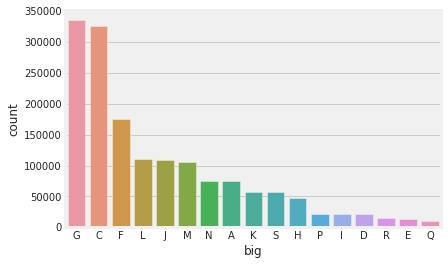

In [ ]:
sns.countplot(data=data, x='big', order = data['big'].value_counts().index)

class가 너무 imbalanced 하므로 <u>Sampling</u>이 필요해보임   
  (P, I, D, R, E, Q 얘네들이라도 오버샘플링.... ) 

In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

import warnings
warnings.filterwarnings('ignore')

## 각각 대분류별 10만개정도로 맞추자

In [14]:
data_under = data.query('big in ["G","C","F", "L", "J", "M"]')
data_under.head(1)

,company,big,token
0,1000000,F,"[토목, 건축, 주택, 분양, 임대업, 경공, 산업, 설비, 시설물, 유지관리, 골..."


In [52]:
X = data_under[['company', 'token']]
y = data_under['big']

us = RandomUnderSampler(random_state=0)
X_under, y_under = us.fit_resample(X, y)

In [54]:
pd.Series(y_under).value_counts()

F    106443
J    106443
L    106443
C    106443
M    106443
G    106443
dtype: int64

In [60]:
undered = pd.DataFrame(X_under, columns=['company', 'token'])
undered['big'] = y_under

In [67]:
data_over = data.query('big not in ["G","C","F", "L", "J", "M"]')
data_over.head(1)

,company,big,token
26,1000107,S,"[자동차, 정비, 자동차, 부속품, 자동차, 견인, 운수업, 철도, 차량, 정비, ..."


In [68]:
X = data_over[['company', 'token']]
y = data_over['big']

us = RandomOverSampler(random_state=0)
X_over, y_over = us.fit_resample(X, y)

In [69]:
overed = pd.DataFrame(X_over, columns=['company', 'token'])
overed['big'] = y_over

In [71]:
overed.big.value_counts()

E    75069
Q    75069
R    75069
S    75069
P    75069
N    75069
K    75069
D    75069
I    75069
H    75069
A    75069
Name: big, dtype: int64

In [79]:
sample_data =pd.concat([overed, undered]).reset_index(drop=True)

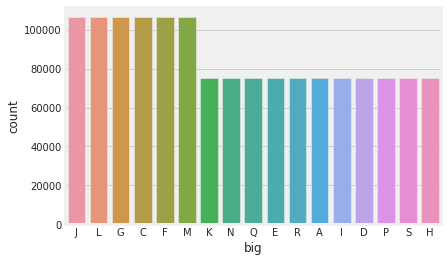

In [80]:
sns.countplot(data=sample_data, x='big', order = sample_data['big'].value_counts().index)

split 

In [81]:
sample_data.head(1)

,company,token,big
0,1000107,"[자동차, 정비, 자동차, 부속품, 자동차, 견인, 운수업, 철도, 차량, 정비, ...",S


In [82]:
sample_data.shape

(1464417, 3)

In [86]:
# sample_data.to_pickle('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/대분류sample.pkl')

In [84]:
X =  [x for x in sample_data.iloc[:,-2]]
Y = pd.get_dummies(sample_data['big']).values   # 대분류 get dummy로 펼치기 

# split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1214)
tr_x, val_x, tr_y, val_y = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=1214)  # valid set 추가
print(len(tr_x), len(val_x), len(Xtest))  # 100만개, 20만개, 30만개

937226 234307 292884


In [ ]:
# Max_len 정해서 패딩함 
def pad(data, max_len=50):    
    result = []
    for tokens in tqdm(data, desc='Padding'):
        if len(tokens) >= max_len:          # max_len보다 크면 그냥 max_len까지만 자르기 
            result.append(tokens[:max_len])
        else:                                          # 패딩이 필요한 개수 
            n_to_pad = max_len - len(tokens)  
            result.append(tokens + [''] * n_to_pad)

    return max_len, result

def padding_text(tokenized_sentences):
    max_tokens, padded_sentences = pad(tokenized_sentences)
    return padded_sentences

In [ ]:
# 패딩 시행 
tr_pad_x = padding_text(tr_x)
# val_pad_x = padding_text(val_x)
# te_pad_x = padding_text(Xtest)

Padding: 100%|██████████| 1010375/1010375 [00:09<00:00, 109502.83it/s]


In [ ]:
tr_pad_x[0]    # padding은 이런식으로 됨

['비철',
 '수출입',
 '비철',
 '무역업',
 '비철',
 '유통',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

#2. Embedding
- Fast text

In [ ]:
EMBEDDING_DIM = 300   # 300개의 임베딩차원으로 이루어진 pretrained fast text 

fasttext_model_path = '/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/cc.ko.300.bin'

In [ ]:
# fasttext model load 
# fasttext_model_cache = {}

# if fasttext_model_path not in fasttext_model_cache:
#   fasttext_model_cache[fasttext_model_path] = fasttext.load_model(fasttext_model_path)  

# fasttext_model = fasttext_model_cache[fasttext_model_path]   

fasttext_model = fasttext.load_model(fasttext_model_path)  

In [ ]:
# fast text에서 word vector 얻기 
def get_word_vectors(words):
    result = []
    for word in words:  # 단어별로 
        if not word: 
            result.append(np.zeros((EMBEDDING_DIM,)))   # 단어가 없으면 0으로 채운다
        else:
            result.append(fasttext_model.get_word_vector(word))
    return np.array(result)  # 여기 array아니라 list로 해야하나

In [ ]:
# 배치단위로 가져오기 
def bring_words_per_batch(x_data, batch_size=64):
  batch_len = math.ceil(len(x_data)/batch_size)   # 해당 배치 size의 반복 횟수 (batch_size*batch_len=len(origin_data)) 
  word_vectors = []

  # 배치단위로 반복하며 word를 가져온다
  for idx in tqdm_notebook(range(batch_len)):   # idx는 배치 인덱스 
    batch_x = x_data[idx * batch_size :(idx + 1) * batch_size] 
    word_vectors.append([get_word_vectors(ps) for ps in batch_x])    # 해당 word 가져와서 리스트에 추가

  return word_vectors   # x_data에 해당하는 fasttext 임베딩 단어

    # batch_y = y_data[idx * batch_size :(idx + 1) * batch_size]    # 배치에 해당하는 y데이터 

In [ ]:
bring_words_per_batch(tr_x)   # 근데 이거 램이 터져버림,,,,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


# TF-IDF + Modeling

In [92]:
from collections import Counter
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
import sys 
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [2]:
# preprocessing 
def drop_token(x):
    sw = ['부대사업','사업','부대','각호','판매업', '한다', '거나', '에게', '따른']   # stopwords
    x = [word for word in x if not word in sw]

    if len(x)>50:         # drop 
      return x[:50]
    else:
      return x     # 중복 제거 안함 

In [3]:
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Competition/KED 대상팀/data/final_data/0504_alltoken.pkl')
data = data.query('big not in ["O","U","T"]')   # o,u,t 제외 

In [87]:
sample_data.head()

,company,token,big
0,1000107,"[자동차, 정비, 자동차, 부속품, 자동차, 견인, 운수업, 철도, 차량, 정비, ...",S
1,1000206,"[산업, 용품, 세탁업, 가정용품, 세탁업, 세탁물, 공급, 섬유, 염색, 표백, ...",S
2,1000294,"[타이어, 공업, 발전, 조사, 연구, 회원, 공동, 이익, 증진, 타이어, 공업,...",S
3,1000305,"[조합, 피복, 공업, 건전, 발전, 조합원, 상호, 복리, 증진, 도모, 협동, ...",S
4,1000330,"[이미용, 서비스업, 이미용, 기기, 제조, 소매업, 이미용, 차이, 화장품, 제조...",S


In [89]:
X = [' '.join(x) for x in sample_data.iloc[:,-2]] 
Y = pd.get_dummies(sample_data['big']).values   # 대분류 get dummy로 펼치기 

Xtrain, te_x, Ytrain, te_y = train_test_split(X, Y, test_size=0.2, random_state=1214)
tr_x, val_x, tr_y, val_y = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=1214)  # valid set 추가

In [90]:
tr_x[0]

'악세사리 디자인 의류 디자인 신발 디자인'

In [93]:
%%time
# preprocessor = TfidfVectorizer(max_features=500)   # tf-idf
preprocessor = TfidfVectorizer(min_df=1, ngram_range=(1,1), lowercase=True, max_features=500)   
## 유니그램, frequency가 1이상인 것만 추출 
X_train_p = preprocessor.fit_transform(tr_x, tr_y).toarray()
X_valid_p = preprocessor.transform(val_x).toarray()    
X_test_p = preprocessor.transform(te_x).toarray()    

CPU times: user 31.6 s, sys: 1.56 s, total: 33.2 s
Wall time: 33.1 s


In [94]:
print(X_train_p.shape, X_valid_p.shape, X_test_p.shape)  # 패딩 안해도될듯? 

(937226, 500) (234307, 500) (292884, 500)


In [95]:
# 단어별 idf 출력 + 정렬해봄
from operator import itemgetter
words = []
for i, j in zip(preprocessor.vocabulary_, preprocessor.idf_):
  words.append((i, j))
words.sort(key=itemgetter(1))
pprint(words[490:])   # 클수록 자주 등장하는 애들임

[('생산', 5.9686648246978145),
 ('경영', 5.969125335873349),
 ('중개', 5.98678378728029),
 ('조합', 5.987096384969613),
 ('방지', 6.008106556749111),
 ('조경', 6.023550879176585),
 ('거래', 6.047506085378071),
 ('문업', 6.059534295880074),
 ('기반', 6.090080139708784),
 ('비디오', 6.451892399970549)]


# Modeling 

In [96]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

In [97]:
print(tr_y.shape, val_y.shape, te_y.shape)  # class 별로 있음 

(937226, 17) (234307, 17) (292884, 17)


In [98]:
n_features = 500      # tf-idf 차원
n_classes = 17        # out 제외

In [99]:
# 원래 모델 
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), 
                                            input_shape=(None, n_features)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dense(17, activation='softmax'))    ## 17개의 대분류 분류
    model.summary() 
    return model

model = build_model()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 256)         644096    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 17)                1105      
Total params: 1,055,889
Trainable params: 1,055,889
Non-trainable params: 0
_________________________________________________________________


In [14]:
# ## input 2d에서 3d로 바꿔야함!!
# def build_model():
#     inp = Input(shape=(None,n_features))
#     x = Bidirectional(GRU(256, return_sequences=True))(inp)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     outp = Dense(17, activation="softmax")(conc)
    
#     model = Model(inputs=inp, outputs=outp)
#     model.summary()

#     return model

# model = build_model()    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 500)]  0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 512)    1164288     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 512)          0           bidirectional[0][0]              
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 512)          0           bidirectional[0][0]              
______________________________________________________________________________________________

In [33]:
X_train_p.shape

(1010375, 500)

In [46]:
X_train_p.reshape(-1, 1, 500).shape

(1010375, 1, 500)

In [100]:
batch_size =  512
epoch = 10

X_train_p_re = X_train_p.reshape(-1, 1, 500)
X_valid_p_re = X_valid_p.reshape(-1, 1, 500)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
history = model.fit(X_train_p_re, tr_y, epochs=epoch, validation_data=(X_valid_p_re, val_y), batch_size=512) 

Epoch 1/10
1831/1831 [==============================] - 32s 7ms/step - loss: 1.2108 - accuracy: 0.6423 - val_loss: 0.8664 - val_accuracy: 0.7244
Epoch 2/10
1831/1831 [==============================] - 12s 6ms/step - loss: 0.8468 - accuracy: 0.7296 - val_loss: 0.8391 - val_accuracy: 0.7301
Epoch 3/10
1831/1831 [==============================] - 12s 6ms/step - loss: 0.8261 - accuracy: 0.7335 - val_loss: 0.8198 - val_accuracy: 0.7359
Epoch 4/10
1831/1831 [==============================] - 12s 6ms/step - loss: 0.8003 - accuracy: 0.7400 - val_loss: 0.8086 - val_accuracy: 0.7384
Epoch 5/10
1831/1831 [==============================] - 12s 6ms/step - loss: 0.7852 - accuracy: 0.7434 - val_loss: 0.7974 - val_accuracy: 0.7405
Epoch 6/10
1831/1831 [==============================] - 12s 6ms/step - loss: 0.7680 - accuracy: 0.7479 - val_loss: 0.7811 - val_accuracy: 0.7456
Epoch 7/10
1831/1831 [==============================] - 12s 7ms/step - loss: 0.7487 - accuracy: 0.7540 - val_loss: 0.7727 - val_ac

더 학습시켜볼만함 

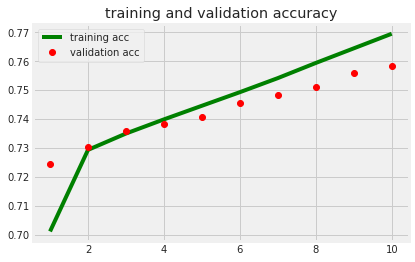

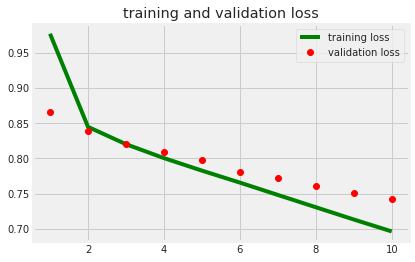

In [101]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## 단순 Dense

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, SimpleRNN, Dropout

model = Sequential()
model.add(Dense(3000, kernel_initializer= 'he_normal', activation='relu', input_dim=500))
model.add(Dropout(0.5))
model.add(Dense(1000, kernel_initializer= 'he_normal', activation='relu'))

model.add(Dense(300, kernel_initializer= 'he_normal', activation='relu'))   # 원래 50
model.add(Dropout(0.5))

model.add(Dense(17, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 3000)              1503000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              3001000   
_________________________________________________________________
dense_19 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 17)                5117      
Total params: 4,809,417
Trainable params: 4,809,417
Non-trainable params: 0
____________________________________________

In [119]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [120]:
history = model.fit(X_train_p, tr_y, epochs=20, batch_size=512, validation_split=0.2)

Epoch 1/20
1465/1465 [==============================] - 9s 6ms/step - loss: 1.0584 - accuracy: 0.6848 - val_loss: 0.8225 - val_accuracy: 0.7375
Epoch 2/20
1465/1465 [==============================] - 8s 5ms/step - loss: 0.8347 - accuracy: 0.7386 - val_loss: 0.7732 - val_accuracy: 0.7518
Epoch 3/20
1465/1465 [==============================] - 8s 5ms/step - loss: 0.7677 - accuracy: 0.7551 - val_loss: 0.7365 - val_accuracy: 0.7627
Epoch 4/20
1465/1465 [==============================] - 8s 5ms/step - loss: 0.7096 - accuracy: 0.7706 - val_loss: 0.7129 - val_accuracy: 0.7713
Epoch 5/20
1465/1465 [==============================] - 8s 6ms/step - loss: 0.6664 - accuracy: 0.7820 - val_loss: 0.6898 - val_accuracy: 0.7786
Epoch 6/20
1465/1465 [==============================] - 8s 5ms/step - loss: 0.6274 - accuracy: 0.7926 - val_loss: 0.6816 - val_accuracy: 0.7834
Epoch 7/20
1465/1465 [==============================] - 8s 5ms/step - loss: 0.5973 - accuracy: 0.8006 - val_loss: 0.6752 - val_accuracy:

In [116]:
model.evaluate(X_test_p,te_y)  # 많이 오르긴함... 샘플링한게 

9153/9153 [==============================] - 16s 2ms/step - loss: 0.7175 - accuracy: 0.7981


[0.7175302505493164, 0.7980667948722839]

In [27]:
model.evaluate(X_test_p,te_y)  # 그냥 dense일 때 

9867/9867 [==============================] - 20s 2ms/step - loss: 0.9252 - accuracy: 0.7172


[0.9251856803894043, 0.7172320485115051]

In [ ]:
from sklearn.model_selection import StratifiedKFold
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512)

샘플링 한게 훨씬 좋음

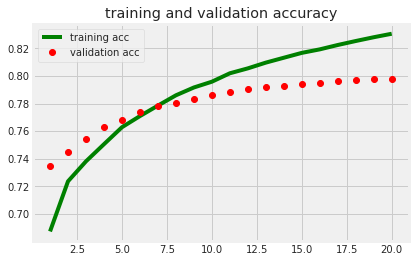

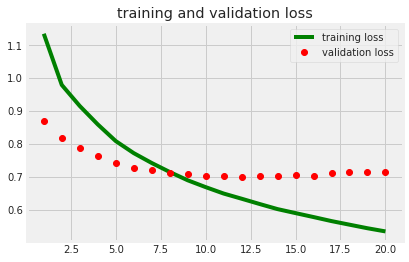

In [117]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

이건 하기 전 

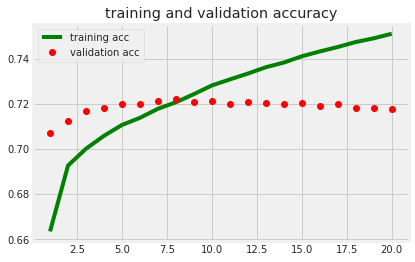

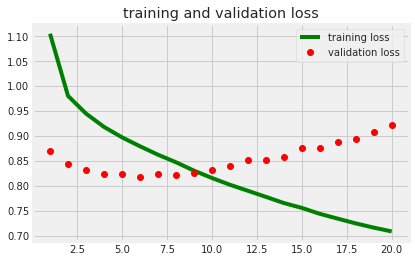

In [26]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'g',label='training acc')
plt.plot(epochs,val_acc,'ro',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'g',label='training loss')
plt.plot(epochs,val_loss,'ro',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()